In [100]:
from pycbc.waveform import get_td_waveform
#from pycbc.waveform import td_approximants 
#import pycbc.catalog
import pylab
import ringdown.qnms
import numpy as np
import matplotlib.pyplot as plt
import qnm
import lal
from collections import namedtuple
import math
T_MSUN = lal.MSUN_SI * lal.G_SI / lal.C_SI**3
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import arviz as az
from pycbc.types import TimeSeries
import ringdown as rd
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit
sns.set(context='notebook', palette='colorblind')

In [2]:
#print(td_approximants())

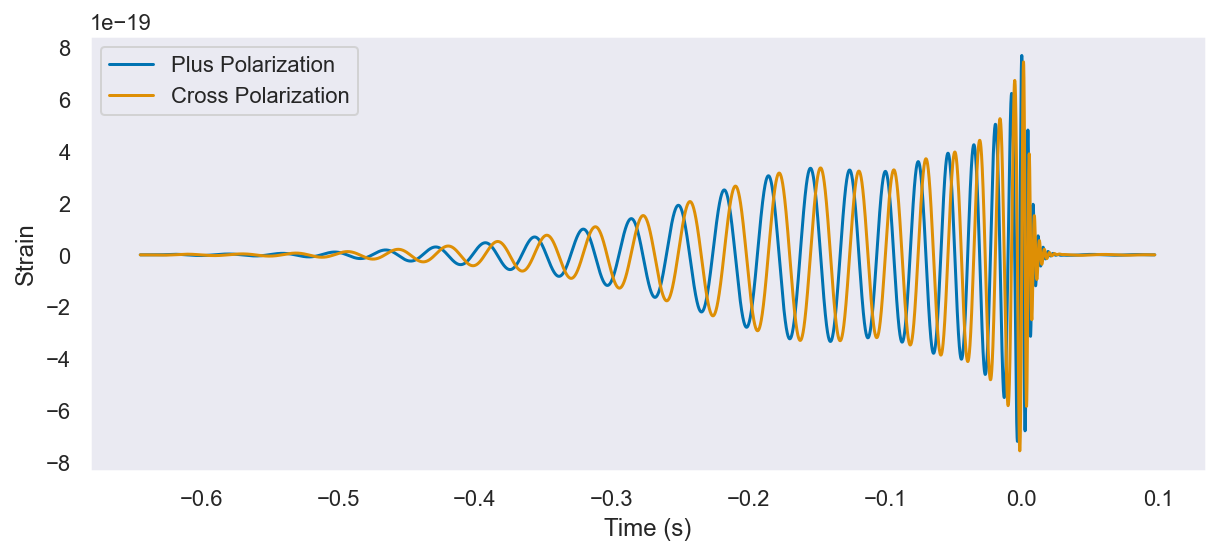

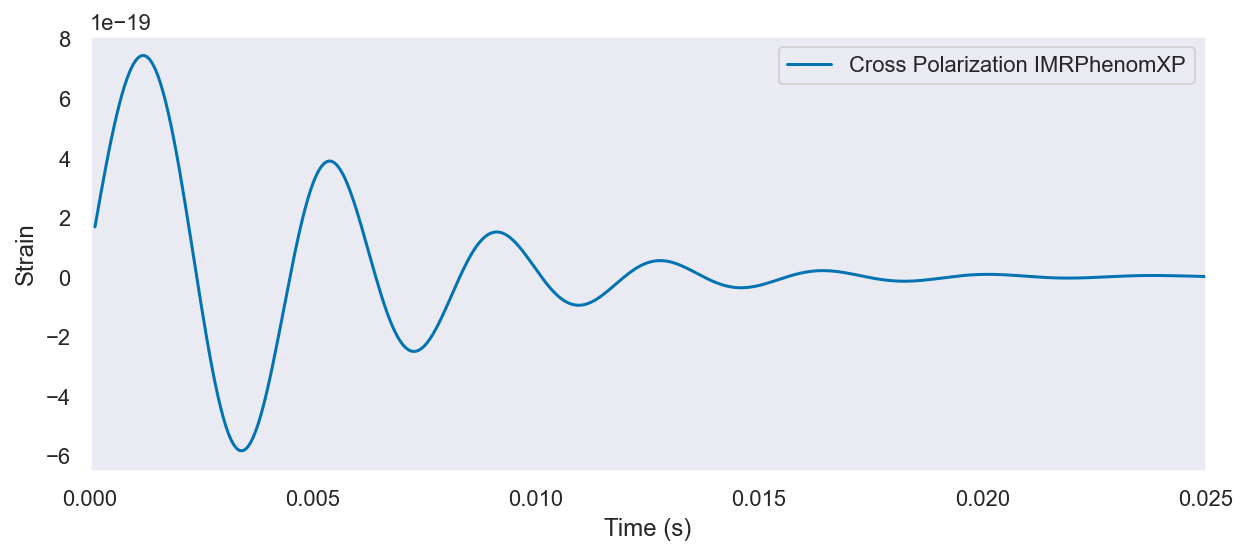

In [3]:
hp, hc = get_td_waveform(approximant="IMRPhenomXP",
                         mass1=36,
                         mass2=29,
                         delta_t=1.0/16384,
                         f_lower=30)

# this is trimming timeseries hp.sample_times and hp/hc data to start at 0 for ringdown analysis
hp_smp_ts = TimeSeries(hp.sample_times, delta_t=1/16384, epoch=0) #turning sample times into timeseries to use crop
cond = hp_smp_ts.crop(0.645,0) #using crop on timeseries sample times 
#use cond for cropped sample times!!!!!

hp_data = TimeSeries(hp, delta_t=1/16384, epoch=0) #turning h+ data into timeseries to use crop
cond_hp = hp_data.crop(0.645,0) #using crop on timeseries data
#use cond_hp for the cropped hp data pts!!!!
#repeating for hx data points
hc_data = TimeSeries(hc, delta_t=1/16384, epoch=0)
cond_hc = hc_data.crop(0.645,0)
hc_signal = cond_hc.numpy() #turning into ndarray

#plotting full IMR +/x no crop
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

#plotting cropped sample times and data for plus
pylab.figure(figsize=pylab.figaspect(0.4))
#pylab.plot(cond, cond_hp, label='Plus Polarization')
pylab.plot(cond, cond_hc, label='Cross Polarization IMRPhenomXP')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(0, .025)
pylab.legend()
pylab.grid()
pylab.show()

#this waveform generated with masses from GW150914

In [32]:
def rngdwn(M,chi,l,m,n,amplitude,phi):
    pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,n,l,m)
    gamma = (ftau[1])**-1
    t0=0
    time = cond.numpy()
        
    wf_kws = dict(
    A = amplitude,
    phi = phi,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return rd.Data(s, index=time)

    signal = get_signal(time, **wf_kws)
    
    return signal

In [70]:
time = cond.numpy()

<Figure size 720x288 with 0 Axes>

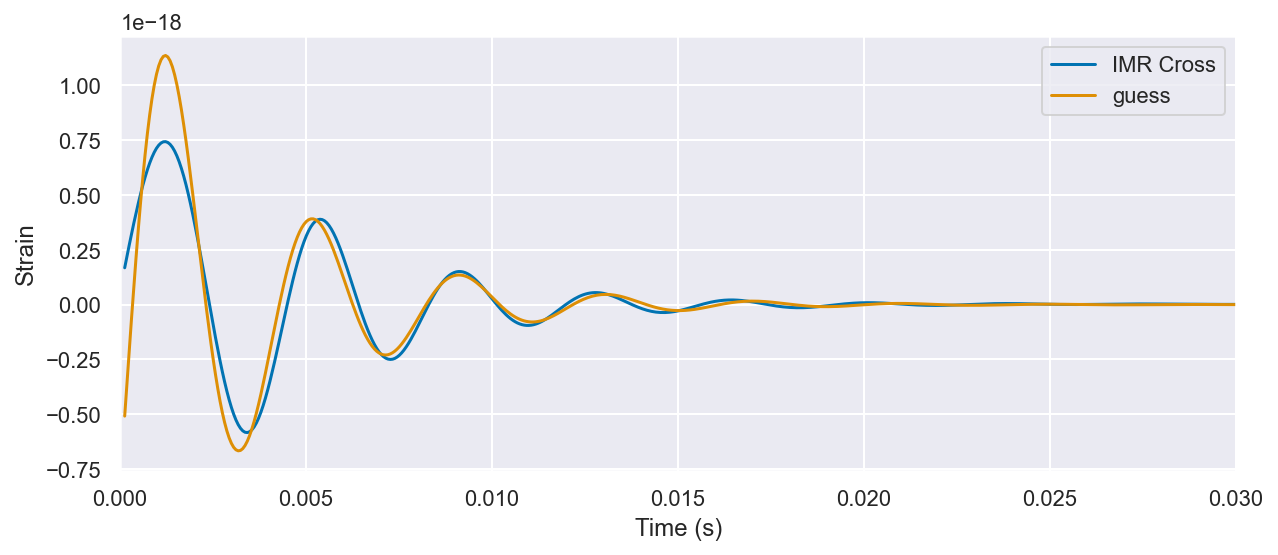

In [115]:
pylab.figure(figsize=pylab.figaspect(0.4))
zero = rngdwn(63,0.6,2,2,0,1.6e-18,-2.1)  #76 0.8 1e-18 0
pylab.plot(cond, cond_hc, label='IMR Cross')
pylab.plot(zero,label='guess')
pylab.xlim(0, 0.03)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
plt.savefig('220_IMR',bbox_inches='tight')
#print(dir(signal))
#print(signal._values)

In [73]:
residual0 = (zero._values) - (cond_hc)

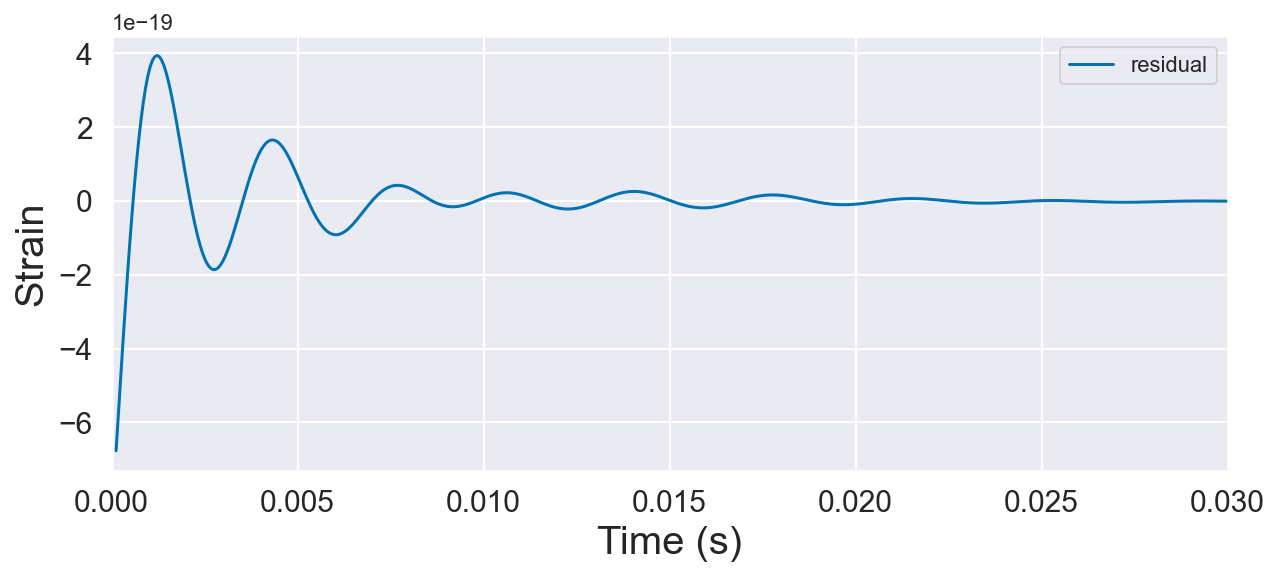

In [74]:
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(time,residual0,label='residual')
pylab.xlim(0, 0.03)
pylab.xlabel('Time (s)',fontsize=20)
pylab.ylabel('Strain',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
#plt.savefig('residual',bbox_inches='tight')

<Figure size 720x288 with 0 Axes>

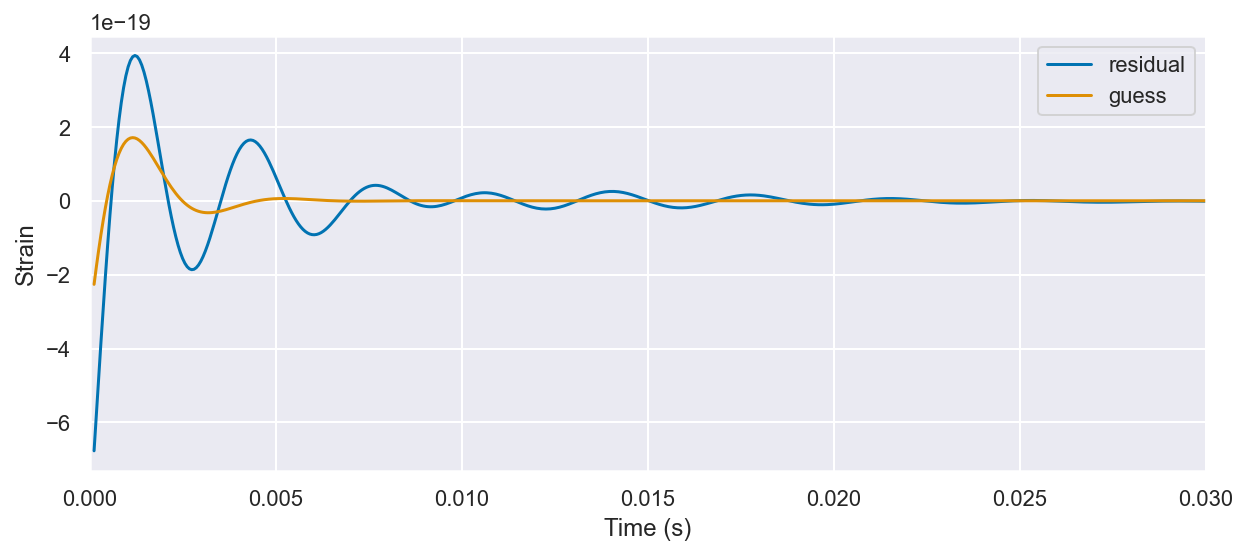

In [93]:
pylab.figure(figsize=pylab.figaspect(0.4))
one = rngdwn(63,0.6,2,2,1,.5e-18,4)
pylab.plot(time,residual0,label='residual')
pylab.plot(one,label='guess')
pylab.xlim(0, 0.03)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()

In [356]:
residual1 = (one._values) - (cond_hc)

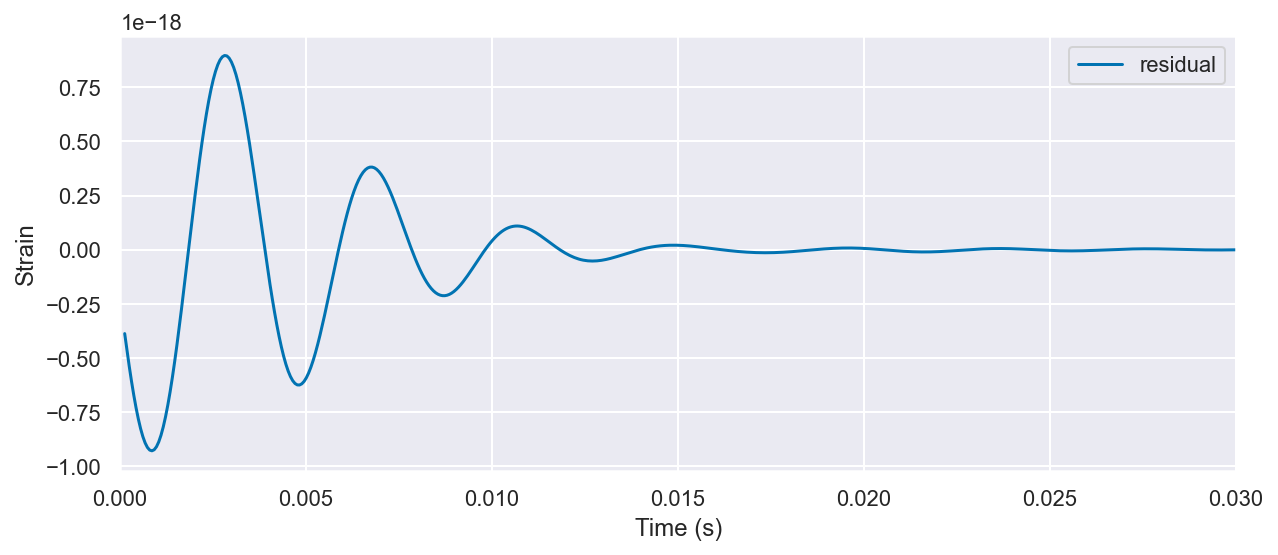

In [357]:
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(time,residual1,label='residual')
pylab.xlim(0, 0.03)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()

In [358]:
def rngdwn_ot(M,chi,l,m,amplitude,phi):
    overtones = np.arange(0,5,1)
    pylab.figure(figsize=pylab.figaspect(0.4))
    for ot in overtones:
        ftau = ringdown.qnms.get_ftau(M,chi,ot,l,m)
        gamma = (ftau[1])**-1
        
        time = cond.numpy()
        
        wf_kws = dict(
        A = amplitude,
        phi = phi,
        f = ftau[0],
        gamma = gamma,
        )

        def get_signal(time, A, phi, f, gamma):
            s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
            return rd.Data(s, index=time)

        signal = get_signal(time, **wf_kws)
        
        pylab.plot(signal,label=f'n = ${{{ot}}}$')
        pylab.xlim(0, 0.03)
        pylab.xlabel('Time (s)')
        pylab.ylabel('Strain')
        pylab.legend()

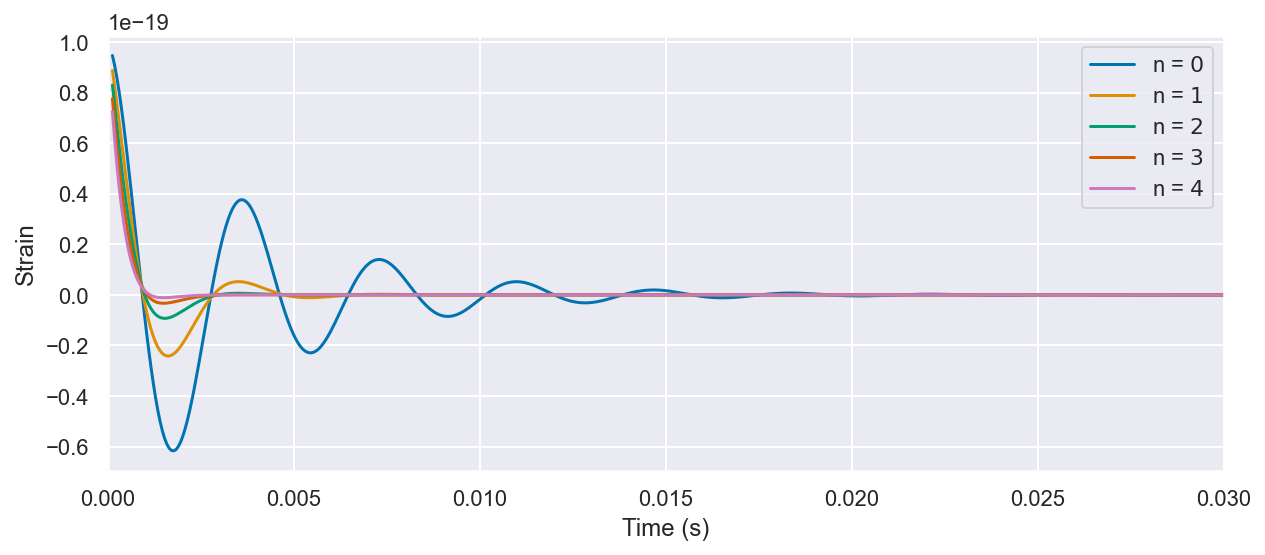

In [359]:
rngdwn_ot(62,0.67,2,2,1e-19,0)

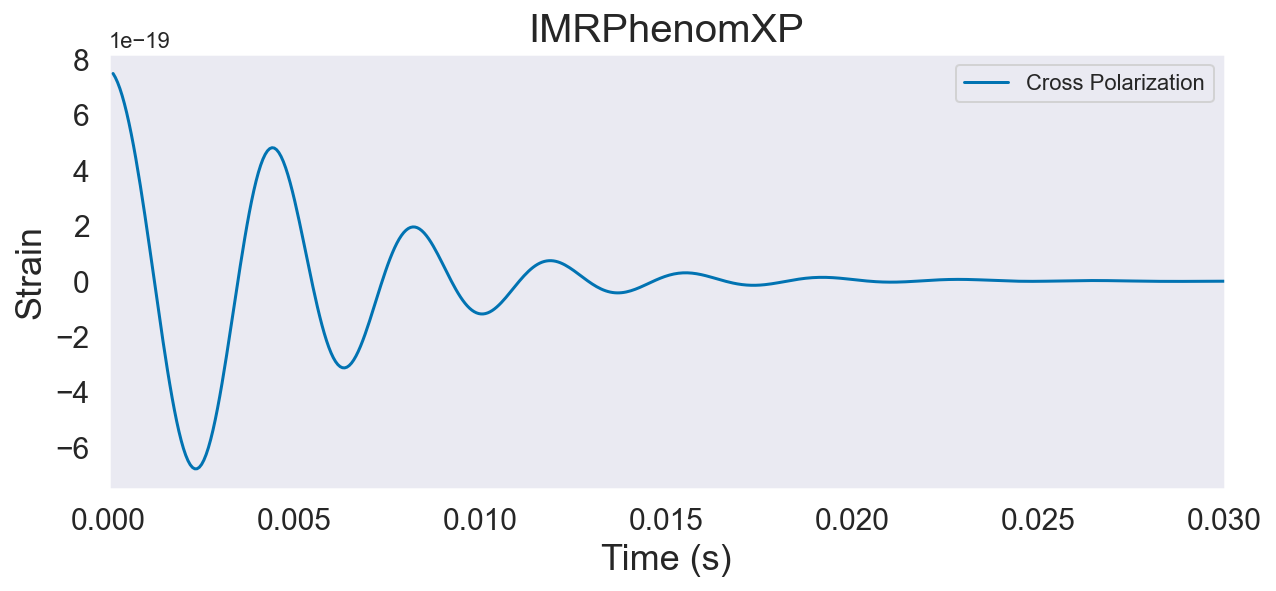

In [363]:
#comparison of IMR and simulated sin with overtones
#rngdwn(79,0.67,2,2,0,1e-18,0)
#plt.title('22n',fontsize=20)
pylab.figure(figsize=pylab.figaspect(0.4))
#pylab.plot(cond, cond_hp, label='Plus Polarization')
pylab.plot(cond, cond_hc, label='Cross Polarization')
pylab.xlabel('Time (s)',fontsize=18)
pylab.ylabel('Strain',fontsize=18)
pylab.xlim(0, .03)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('IMRPhenomXP',fontsize=20)
pylab.legend()
pylab.grid()
pylab.show()

In [117]:
import surfinBH
fit_name = 'NRSur3dq8Remnant'
fit = surfinBH.LoadFits(fit_name)

Loaded NRSur3dq8Remnant fit.


In [118]:
q = 1.24             # Mass ratio q>=1
chiA = [0,0,0]    # Spin of larger BH (z-direction only)
chiB = [0,0,0]    # Spin of smaller BH (z-direction only)

## Evaluate the fits and GPR error estimate.

# remnant mass and 1-sigma error estimate
mf, mf_err = fit.mf(q, chiA, chiB)

# remnant spin and 1-sigma error estimate
chif, chif_err = fit.chif(q, chiA, chiB)

# remnant recoil kick and 1-sigma error estimate
vf, vf_err = fit.vf(q, chiA, chiB)

# All of these together
mf, chif, vf, mf_err, chif_err, vf_err = fit.all(q, chiA, chiB)

In [119]:
print(mf, chif)
m_f = mf*(36+29)
print(m_f)
# mf is returning m2/m1...so multiply it by (m1+m2)!!!!

0.9526684300679796 [0.         0.         0.68007186]
61.92344795441868


<Figure size 720x288 with 0 Axes>

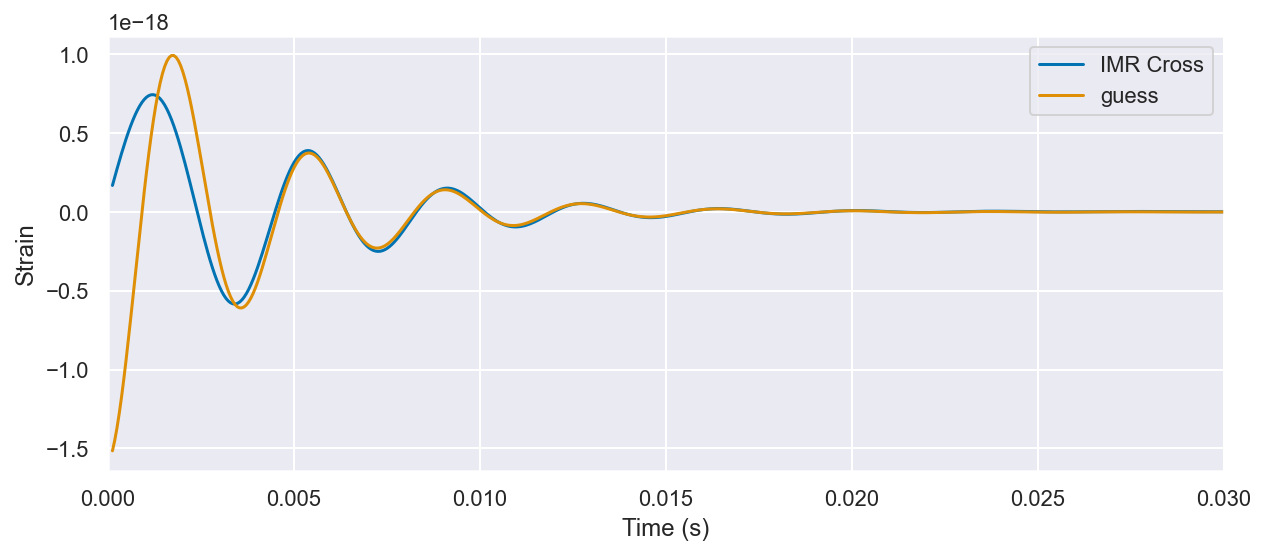

In [125]:
pylab.figure(figsize=pylab.figaspect(0.4))
surfin = rngdwn(62,0.68,2,2,0,1.6e-18,np.pi)
pylab.plot(cond, cond_hc, label='IMR Cross')
pylab.plot(surfin,label='guess')
pylab.xlim(0, 0.03)
#pylab.axvline(x=0.0085,linestyle='dashed') use this for 1e-18 and phi=0
#pylab.axvline(x=0.0115,linestyle='dashed')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
#plt.savefig('hmfit')
#print(dir(signal))
#print(signal._values)

In [126]:
surfin_res = (surfin._values) - (cond_hc)

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

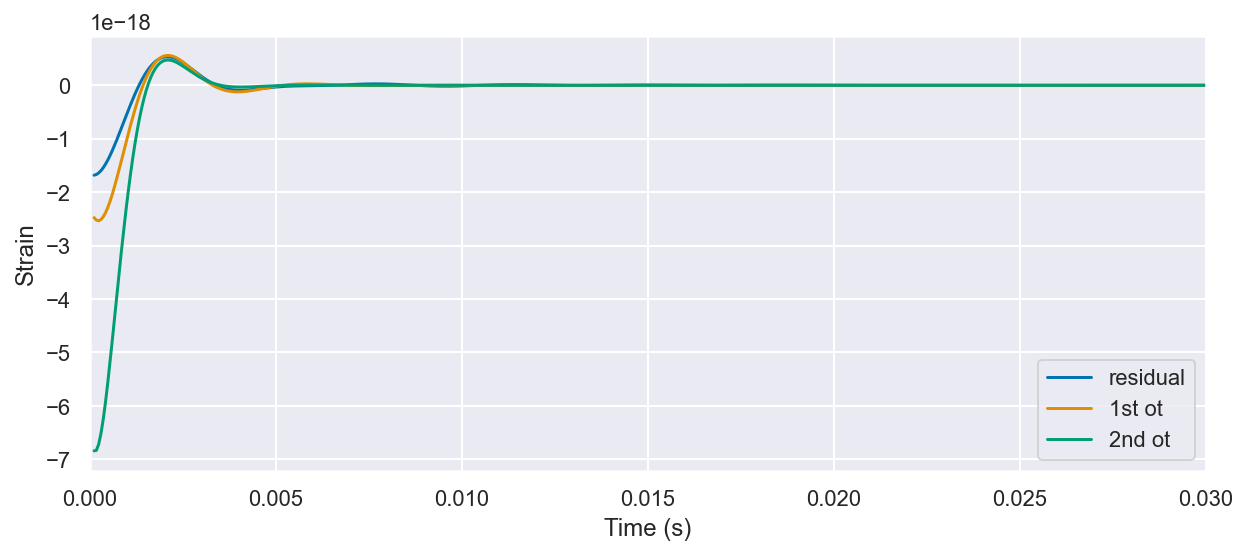

In [172]:
pylab.figure(figsize=pylab.figaspect(0.4))
surfin1 = rngdwn(62,0.68,2,2,1,3.4e-18,2.3)
surfin2 = rngdwn(62,0.68,2,2,2,11e-18,2.2)
pylab.plot(time,surfin_res,label='residual')
pylab.plot(surfin1,label='1st ot')
pylab.plot(surfin2,label='2nd ot')
pylab.xlim(0, 0.03)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()